# SpM analytic continuation
Author: Kazuyoshi Yoshimi & Junya Otsuki

This example provides an application of `sparse-ir` to the sparse-modeling analytic continuation (SpM) algorithm. We reproduce the result presented in the original paper {cite:p}`Otsuki:2017er`.

The analytic continuation can be formulated as the inverse problem of the equation

$$
  G(\tau) = -\int_{-\infty}^{\infty} d\omega K(\tau, \omega) \rho(\omega).
$$ (lehmann-spm)

We evaluate $\rho(\omega)$ for a given $G(\tau)$.
<!-- Because of ill-conditioned nature of the kernel function $K$, the inversion of this equation is sensitive to noise in $G(\tau)$. SpM method extract relevant information in $G(\tau)$ using $L_1$-norm regularization. -->


## Preparation

In [1]:
!pip install sparse_ir
!pip install admmsolver

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


We use a sample data provided in the repository **SpM-lab/SpM**.

In [2]:
# Download data for G(tau) and rhow(omega) from GitHub repo
from urllib.request import urlretrieve
base_url = "https://raw.githubusercontent.com/SpM-lab/SpM/master/samples/fermion/"
for name in ["Gtau.in", "Gtau.in.dos"]:
    urlretrieve(base_url + name, name)
# Alternatively, we can use the following command:
#!wget https://raw.githubusercontent.com/SpM-lab/SpM/master/samples/fermion/Gtau.in
#!wget https://raw.githubusercontent.com/SpM-lab/SpM/master/samples/fermion/Gtau.in.dos

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Input data for $G(\tau)$

We load the sample data provided in the repository **SpM-lab/SpM**.

In [4]:
#Load Gtau
Gtau = np.loadtxt("Gtau.in")[:, 2]

# Set imaginary-time
beta = 100
ntau = len(Gtau)
ts = np.linspace(0.0, beta, ntau)

Let us plot the input data loaded.

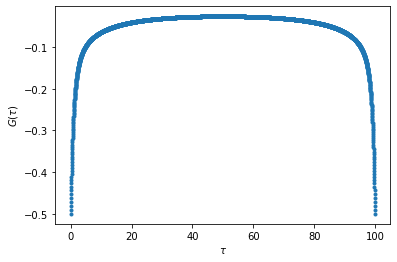

In [5]:
# Plot G(tau)
fig, ax = plt.subplots()
ax.plot(ts, Gtau, '.')
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$G(\tau)$")
plt.show()

## Spectral function $\rho(\omega)$ (answer)

We generate the real frequency grid for the spectral function $\rho(\omega)$

In [6]:
#Set omega
Nomega = 1001
omegamin = -4
omegamax = 4
ws = np.linspace(-omegamax, omegamax, num=Nomega)

The exact spectrum is provided as well. The spectrum is plotted below.

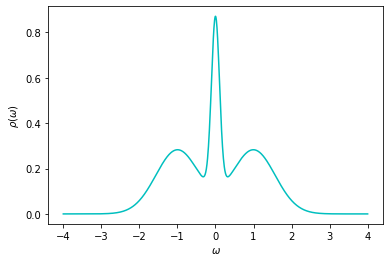

In [7]:
rho_answer = np.loadtxt("Gtau.in.dos")[:, 1]

# Plot rho(omega)
fig, ax = plt.subplots()
ax.plot(ws, rho_answer, '-c')
ax.set_xlabel(r"$\omega$")
ax.set_ylabel(r"$\rho(\omega)$")
plt.show()

## IR basis

We first generate IR basis.
On a discrete grid of $\{ \tau_i \}$ and $\{ \omega_j \}$, the kernel function $K(\tau, \omega)$ are represented by a matrix $\hat{K}$ with $\hat{K}_{ij}=K(\tau_i, \omega_j)$. The singular value decomposition of $\hat{K}$ defines the IR basis

$$
\hat{K} = \hat{U} \hat{S} \hat{V}^\mathrm{T},
$$

where

$$
\hat{U}_{il}=U_l(\tau_i),
\quad
\hat{S}_{ll} = S_l,
\quad
\hat{V}_{jl}=V_l(\omega_j).
$$

The matrices $\hat{U}$, $\hat{S}$, and $\hat{V}$ can be computed by ``sparse_ir.FiniteTempBasis`` class (https://sparse-ir.readthedocs.io/en/latest/basis.html).

In [8]:
import sparse_ir

#Set basis
SVmin = 1e-10
basis = sparse_ir.FiniteTempBasis(
            statistics="F", beta=beta, wmax=omegamax, eps=SVmin
        )
U = basis.u(ts).T
S = basis.s
V = basis.v(ws).T

``U`` and ``V`` are two-dimensional ndarray (matrices), while ``S`` is a one-dimensional ndarray. Let us confirm it by printing the shapes explictly.

In [9]:
print(f"{U.shape}, {S.shape}, {V.shape}")

(4001, 43), (43,), (1001, 43)


## SpM analytic continuation

The spectral function $\rho(\omega)$ can be expanded with the IR basis

$$
\rho(\omega) = \sum_l \rho_l V_l(\omega)
$$

The SpM analytic continuation algorithm evaluates the coefficient $\{ \rho_l \}$.
Eq. {eq}`lehmann-spm` is rewritten in terms of the IR basis by

$$
G(\tau_i) = \sum_l \hat{U}_{il} S_l \rho_l
$$

We represent this equation with the conventional notation

$$
\boldsymbol{y} =A \boldsymbol{x},
$$

where

$$
y_i = -G(\tau_i),
\quad
A_{il}\equiv \hat{U}_{il} S_l,
\quad
x_l = \rho_l.
$$

Here, $\boldsymbol{y}$ is an input, and $\boldsymbol{x}$ is the quantity to be evaluated.

In [10]:
y = -Gtau
A = np.einsum("il,l->il", U, S)

SpM evaluates $\boldsymbol{x}$ by solving the optimization problem

$$
\boldsymbol{x}^{\ast} = \underset{\boldsymbol{x}}{\mathrm{arg\,min}} F(\boldsymbol{x}),
$$

where

$$
F(\boldsymbol{x}) = \frac{1}{2} \| \boldsymbol{y} - A\boldsymbol{x} \|_2^2
+ \lambda \| \boldsymbol{x} \|_1
+ \infty \| C\boldsymbol{x} - D \|_2^2
+ \infty \Theta (-V\boldsymbol{x}).
$$

The first term is the least square fitting to the input, the second term is **$L_1$-norm regularization**,
and the third term and the fourth term represent constraints: sum-rule and non-negativity, respectively.

An obtained solution depends on the value of the regularization parameter $\lambda$, which should be optimized based on data science. But, for simplicity, we fix the value of $\lambda$ in this example.

<!-- In the following, we denote the four terms in $F(\boldsymbol{x})$ by $F_i(\boldsymbol{x})$ with $i=1, 2, 3, 4$. -->

**Note:**
In the original SpM paper, the least-square term is evaluated directly in the IR.
Namely, using $\hat{U}\hat{U}^{\dagger}=1$, the least-square term can be converted to

$$
\frac{1}{2} \| \boldsymbol{y} - A\boldsymbol{x} \|_2^2 = \frac{1}{2} \sum_l (G_l - S_l \rho_l)^2.
$$

Because $\hat{U}$ is not a unitary matrix in the present formalism, one cannot use this equation.


## ADMM

We solve the above multi-constaint optimization problem using alternating direction method of multipliers (ADMM).
To this end, we consider an alternative multivariate optimization problem 

$$
\min_{\boldsymbol{x}_0, \boldsymbol{x}_1, \cdots} \tilde{F}(\boldsymbol{x}_0, \boldsymbol{x}_1, \cdots),
$$

subject to equality conditions

$$
E_{ji} \boldsymbol{x}_i = E_{ij} \boldsymbol{x}_j.
$$

Here, the objective function $F$ is given by

$$
\tilde{F}(\boldsymbol{x}_0, \boldsymbol{x}_1, \cdots) = \sum_i F_i(\boldsymbol{x}_i)
$$

We use `admmsolver` package.
The import statement below shows all necessary classes for implementing the present optimization problem.
**Note that `admmsolver` is under active development and its interface is subject to future changes.**

In [11]:
import admmsolver
import admmsolver.optimizer
import admmsolver.objectivefunc
from admmsolver.objectivefunc import (
    L1Regularizer,
    #LeastSquares,
    ConstrainedLeastSquares,
    NonNegativePenalty,
)
from admmsolver.matrix import identity
from admmsolver.optimizer import SimpleOptimizer
print(f"admmsolver=={admmsolver.__version__}")

admmsolver==0.7.4


### $L_2$ norms

The Green's function follows the sum-rule

$$
  \int_{-\infty}^{\infty} d\omega \rho(\omega) = 1
$$

More generally (including the self-energy), the right-hand side is given by $-G(\tau=+0) - G(\tau=\beta-0)$, which is non-zero for orbital-diagonal components and 0 for off-diagonal components.
In the IR basis, the left-hand side is reprenseted by

$$
\int_{-\infty}^{\infty} d\omega \rho(\omega)
= G(\tau=-0) - G(\tau=0^+) 
= \sum_l [U_l(\tau=+0) + U_l(\tau=\beta-0) ] S_l \rho_l.
$$

This sum-rule can be imposed by an infinite penalty. Together with the least-square term, we obtain

$$
  F_0(\boldsymbol{x}_0) = \frac{1}{2} \| \boldsymbol{y} - A\boldsymbol{x}_0 \|_2^2 + \infty \| C\boldsymbol{x}_0 - D \|_2^2.
$$

These $L_2$ norm terms are implemented as ``admmsolver.objectivefunc.ConstrainedLeastSquares`` object.

In [12]:
# sum-rule
rho_sum = y[0] + y[-1]
C = (A[0] + A[-1]).reshape(1, -1)
lstsq_F = ConstrainedLeastSquares(0.5, A=A, y=y, C=C, D=np.array([rho_sum]))

### $L_1$-norm regularization

The $L_1$-norm regularization term

$$
F_1(\boldsymbol{x}_1) = \lambda \| \boldsymbol{x}_1 \|_1
$$

is implemented as ``admmsolver.objectivefunc.L1Regularizer`` object. 
We note that $\boldsymbol{x}_1$ will be finaly converged to $\boldsymbol{x}_0$.

In [13]:
lambda_ = 10**-1.8  # regularization parameter
l1_F = L1Regularizer(lambda_, basis.size)

Here, we use $\lambda=10^{-1.8}$, which was found to be optimal for the present dataset.


### Non-negative constraint

The last term describes the non-negative constraint

$$
  \rho(\omega) \geq 0
$$

Since we have the relation $\rho(\omega_i)=(\hat{V}\boldsymbol{x})_i$, this inequality can be represented as a function
<!-- $$
  F_2(\boldsymbol{x}) = \infty \Theta (-V\boldsymbol{x})
$$ -->

$$
  F_2(\boldsymbol{x}_2) = \infty \Theta (-\boldsymbol{x}_2)
$$

We note that $\boldsymbol{x}_2 = V\boldsymbol{x}_0$ will be imposed later.

In [14]:
nonneg_F = NonNegativePenalty(Nomega)

We now define ``admmsolver.optimizer.Problem`` by integrating the three obejective functions.

In [15]:
objective_functions = [lstsq_F, l1_F, nonneg_F]
equality_conditions = [
    (0, 1, identity(basis.size), identity(basis.size)),
    # (0, 2, V.T, identity(Nomega)),
    (0, 2, V, identity(Nomega)),
]

p = admmsolver.optimizer.Problem(objective_functions, equality_conditions)

``objective_functions`` is a list of functions $F_0(\boldsymbol{x}_0)$, $F_0(\boldsymbol{x}_1)$, $F_0(\boldsymbol{x}_2)$.
Two equality condition is set to ``equality_conditions``.
The first one denotes $\boldsymbol{x}_0 = \boldsymbol{x}_1$, and the second one denotes $V\boldsymbol{x}_0=\boldsymbol{x}_2$.
Thus, the multivariate objective function $\tilde{F}(\boldsymbol{x}_0, \boldsymbol{x}_1, \boldsymbol{x}_2)$ is reduced to the original objective function $F(\boldsymbol{x})$.

We solve the problem defined above using ``admmsolver.optimizer.SimpleOptimizer``.

In [16]:
maxiteration = 1000
initial_mu = 1.0
opt = SimpleOptimizer(p, mu=initial_mu)  # initialize solver
opt.solve(maxiteration)  # solve

Here, ``mu`` is a parameter which controls the convergence, and ``maxiteration`` is the maximum number of iterations.

The converged result is stored in ``opt.x``, which is a list of vectors $\boldsymbol{x}_0$, $\boldsymbol{x}_1$, and $\boldsymbol{x}_2$. We can access each vector by

In [17]:
x0, x1, x2 = opt.x
print(f"{x0.shape}, {x1.shape}, {x2.shape}")

(43,), (43,), (1001,)


The spectral function $\rho(\omega)$ can be reconstructed from the coefficients $\{ \rho_l \}$ stored in $\boldsymbol{x}_0$.

In [18]:
rho = V @ x0

## Plot the results

We plot the spectral function $\rho(\omega)$ computed in the SpM together with the exact solution.

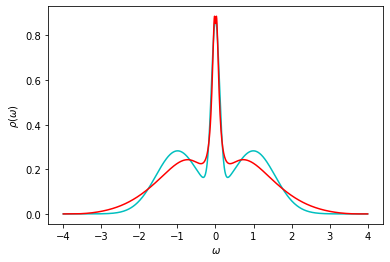

In [19]:
fig, ax = plt.subplots()
ax.plot(ws, rho_answer, '-c')
ax.plot(ws, rho.real, '-r')
ax.set_xlabel(r"$\omega$")
ax.set_ylabel(r"$\rho(\omega)$")
plt.show()

In [20]:
# save results
# specfile = "spectrum.dat"
# with open(specfile, "w") as f:
#     f.write(f"# log_lambda = f{lambdalog}\n")
#     for w, r in zip(ws, rho):
#         f.write(f"{w} {np.real(r)}\n")